# CH4-AIR Notebook 
This notebook contains all the methods and the 2 experiments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
import time
from sklearn.decomposition import PCA, SparsePCA
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
import sys

# Load and prepare data

In [2]:
#read the data into a dataframe
df = pd.read_csv('C:\\Users\\amol\\Documents\\PHD\\DISSERTATION\\NewData_flames_data_with_L1_L2_errors_CH4-AIR_with_trimming.txt')



#create an integer representation of the flame-id and add to the data frame
df['flame_key_int'] = df[' flame_key'].mul(10000000).astype(int)

#create an integer to determine if the flame is included by the framework in the manifold creation and reverselookup
#framework_untrimmed_flameids = [0.00115982, 0.00122087, 0.00128512, 0.00135276, 0.00142396, 0.0014989, 0.00157779, 0.00166083, 0.00174825, 0.00184026, 0.00193711, 0.00203907, 0.00214639, 0.00225936, 0.00237827, 0.01]

framework_untrimmed_flameids = ['2.0276547153583627E-4', '2.1343733845877503E-4', '2.2467088258818426E-4', '2.3649566588229923E-4', '2.4894280619189394E-4', '2.6204505914936203E-4', '2.7583690436774953E-4', '2.903546361765785E-4', '3.056364591332405E-4', '3.2172258856130585E-4', '3.3865535638032194E-4', '0.0032353354497370902']


framework_untrimmed_flame_key_ints = [int(float(framework_untrimmed_flameids[i])*10000000) for i in range(len(framework_untrimmed_flameids))]

def isFlame_included(flame_key_int):
    if flame_key_int in framework_untrimmed_flame_key_ints:
        ret_val = 1
    else:
        ret_val = 0
    return ret_val

df['is_flame_included_by_framework'] = df['flame_key_int'].map(lambda x: isFlame_included(x))

df['souener_deciles'] = pd.qcut(df['souener'],10)


### Create PCAs using all the data and add to DF


In [3]:
num_principal_components = 5

pca = PCA(n_components=num_principal_components)

icovariates = []
for c in df.columns:
    if c[0:2] == 'Yi':
        icovariates.append(c)

X = df[icovariates].values
        
pure_pca_dim_cols = ["PURE_PCA_"+str(i+1) for i in range(num_principal_components)]

pca.fit_transform(X)
        
df_pure_pca = pd.DataFrame(pca.transform(X), columns = pure_pca_dim_cols)
        
df = pd.concat([df,df_pure_pca], axis=1)


### Create Sparse PCA

In [4]:
sparsepca = SparsePCA(n_components=num_principal_components)
      
sparse_pca_dim_cols = ["SPARSE_PCA_"+str(i+1) for i in range(num_principal_components)]

sparsepca.fit_transform(X)
        
df_sparse_pca = pd.DataFrame(sparsepca.transform(X), columns = sparse_pca_dim_cols)
        
df = pd.concat([df,df_sparse_pca], axis=1)

### Create PCAs orthogonal to Zmix and add to DF

In [5]:
zmix_pca_dim_cols = ["Zmix_PCA_"+str(i+1) for i in range(num_principal_components)]

wopt = np.array([0.25131806468584, 1.0, 0.0, 0.0, 0.05926499970012948, 0.11189834407236524, 0.03053739933116691, 0.05926499970012948, 0.0, 0.07742283372149472, 0.14371856860332313, 0.14371856860332313, 0.20112514400193687, 1.0, 0.0, 0.0, 0.03473494419333629, 0.06713785861443991, 0.09743596683886535, 0.09743596683886535, 0.12582790137651187, 0.04027033873046593, 0.07742283372149472, 0.11180607885607882, 0.14371856860332313, 0.17341738612784788, 0.20112514400193687, 0.024566681794273966, 0.04795526192839207, 0.04795526192839207, 0.0, 0.06713048065088474, 0.12581494366075874, 0.17755300484072126, 0.034730994502665966, 0.0, 0.0, 0.0, 0.03249947443158002, 0.0, 0.0372961080230628, 0.07191024382448291, 0.024564706019978535, 0.023426986426879046, 0.023426986426879046, 0.023426986426879046, 0.0, 0.16374935944566987, 0.18286442054789118, 0.07024850027715426, 0.09152158240065958, 0.0, 0.0] , dtype=float)

w = wopt[:,np.newaxis]

# center the data
Xcenter = X - np.mean(X)

A = np.cov(X.T)

# calculate A - ww^TA
L = A - np.dot(np.dot(w,w.T),A)

# get the first eigen vector
values,vectors = np.linalg.eig(L)

vectors = np.real(vectors)

values = np.real(values)

df_zmix_pca = pd.DataFrame(df['flame_key_int'], columns = ['flame_key_int'])

df_zmix_pca[zmix_pca_dim_cols[0]] = Xcenter.dot(wopt)

for i in range(len(zmix_pca_dim_cols)-1):
    df_zmix_pca[zmix_pca_dim_cols[i+1]] = Xcenter.dot(vectors.T[i])

df_zmix_pca = pd.DataFrame(pca.transform(X), columns = zmix_pca_dim_cols)
        
df = pd.concat([df,df_zmix_pca], axis=1)

In [6]:
framework_included_flames_int = df[df['is_flame_included_by_framework'] == 1]['flame_key_int'].unique()

framework_excluded_flames_int = df[df['is_flame_included_by_framework'] == 0]['flame_key_int'].unique()

all_flames_int = df['flame_key_int'].unique()

def getTrainTestFlames(method):
    
    training_flames_int = []

    testing_flames_int = []

    if(method == "frameworkincludedexcludedequalsplit"):
    
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_excluded_flames_int[::2]:
            training_flames_int.append(x)

        for x in framework_included_flames_int:
            testing_flames_int.append(x)

        for x in framework_excluded_flames_int[1::2]:
            testing_flames_int.append(x)
    
    elif(method == "frameworkincludedtrainexcludedtest"):
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_excluded_flames_int:
            testing_flames_int.append(x)
    
    elif(method == "frameworkincludedtrainexcludedandincludedtest"):
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_included_flames_int:
            testing_flames_int.append(x)

        for x in framework_excluded_flames_int:
            testing_flames_int.append(x)
            
    else:
        for x in all_flames_int:
            training_flames_int.append(x)
            testing_flames_int.append(x)
    
    df_training = df[df['flame_key_int'].isin(training_flames_int)]

    df_testing = df[df['flame_key_int'].isin(testing_flames_int)]
    
    return df_training,df_testing


def getTrainTestData(method):
    
    method_parts = method.split('_')

    df_trainingFlames, df_testingFlames = getTrainTestFlames(method_parts[1])

    if method_parts[0] == "ZmixCpv":
        X_train = df_trainingFlames [["Zmix","Cpv"]].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [["Zmix","Cpv"]].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    elif method_parts[0] == "ZmixPCA":
        X_train = df_trainingFlames [zmix_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [zmix_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
        
    elif method_parts[0] == "SparsePCA":
        X_train = df_trainingFlames [sparse_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [sparse_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    elif method_parts[0] == "PurePCA":
        X_train = df_trainingFlames [pure_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [pure_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
        
    else:
        X_train = df_trainingFlames [icovariates].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [icovariates].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    return X_train,Y_train,X_test,Y_test

In [7]:
def computeError (Y_pred, Y_test):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['souener'] = Y_test.flatten()

    evaluation_df_1['souener_pred'] = Y_pred.flatten()

    evaluation_df_1['souener_pred_L1'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 

    evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']
    
    evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener']) 
    
    TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

    TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()
    
    MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()

    MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()
    
    NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()
    
    MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints
    
    return [TotalAbsoluteError,TotalSquaredError,MeanAbsoluteError,MeanSquaredError,MeanPercentageError,NumPoints]

def printError (err):
    TotalAbsoluteError = err[0]

    TotalSquaredError = err[1]

    MeanAbsoluteError = err[2]

    MeanSquaredError = err[3]

    MeanPercentageError = err[4]

    NumPoints = err[5]
    print ('Total Absolute Error: ', TotalAbsoluteError)
    print ('Mean Absolute Error: ', MeanAbsoluteError)
    print ('Mean Percentage Error: ', MeanPercentageError)
    print ('Total Squared Error: ', TotalSquaredError)
    print ('Mean Squared Error: ', MeanSquaredError)
    print ('Number of Points: ', NumPoints)

def computeAndPrintError(Y_pred, Y_test):    
    err = computeError (Y_pred, Y_test)
    printError (err)
    return err



In [8]:
class CustomGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=150, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min




def fitGPAndCalcL1Err(X_train, Y_train, X_test, Y_test,kernel="Matern"):
    
    if kernel == "Matern_RationalQuadratic":
        
        # medium term irregularities
        k1 = 0.5* Matern(length_scale=2, nu=3/2)
        k2 = 0.5* RationalQuadratic(length_scale=1.0, alpha=1.0)
    
        '''
        k4 = 0.1**2 * RBF(length_scale=0.1) \+ WhiteKernel(noise_level=0.1**2,
                      noise_level_bounds=(1e-3, np.inf))  # noise terms
        '''
        kernel = k1 + k2
    
    elif kernel == "RationalQuadratic":
        
        # medium term irregularities
        kernel = RationalQuadratic(length_scale=1.0, alpha=1.0)    
    
    else:
        kernel = Matern(length_scale=2, nu=3/2)
    
    #gp_1 = gaussian_process.GaussianProcessRegressor(kernel=kernel)

    
    t = time.process_time()

    gp_1 = CustomGPR(kernel=kernel)
    
    gp_1.fit(X_train, Y_train)

    elapsed_time = time.process_time() - t

    print ("GP Time for Initial Fit: ", elapsed_time)
    
    t = time.process_time()
    
    #Y_pred = gp_1.predict(X_test, return_std=False)
    Y_pred = gp_1.predict(X_test, return_std=False)
    
    elapsed_time = time.process_time() - t

    print ("GP Time for Prediction: ", elapsed_time)
    
    err = computeAndPrintError(Y_pred, Y_test)
    
    return gp_1, err,Y_pred

In [9]:
df[["Zmix","Zmix_PCA_1","Zmix_PCA_2","Zmix_PCA_3","Zmix_PCA_4","Zmix_PCA_5","souener"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Zmix,16439.0,4.300108e-01,2.603049e-01,4.542561e-03,2.126706e-01,3.964299e-01,6.312398e-01,9.954029e-01
Zmix_PCA_1,16439.0,-1.318301e-17,3.251065e-01,-4.908971e-01,-2.376216e-01,-1.147888e-01,2.351870e-01,7.919453e-01
Zmix_PCA_2,16439.0,-2.182761e-17,2.386448e-01,-3.177493e-01,-1.897668e-01,-4.598998e-02,1.333045e-01,7.843393e-01
Zmix_PCA_3,16439.0,4.497892e-18,6.042086e-02,-1.516243e-01,-2.527337e-02,3.242711e-03,3.535094e-02,1.816229e-01
Zmix_PCA_4,16439.0,-1.031949e-17,1.796528e-02,-4.138498e-02,-1.144243e-02,-1.985400e-03,7.268634e-03,5.825246e-02
Zmix_PCA_5,16439.0,-2.424540e-18,1.219560e-02,-2.677573e-02,-8.928763e-03,-4.546677e-04,8.275492e-03,2.862440e-02
souener,16439.0,1.235775e+10,2.959109e+10,-2.857737e+09,4.570219e+07,1.462231e+09,8.148453e+09,2.041413e+11


In [10]:
df["souener"].describe()

count    1.643900e+04
mean     1.235775e+10
std      2.959109e+10
min     -2.857737e+09
25%      4.570219e+07
50%      1.462231e+09
75%      8.148453e+09
max      2.041413e+11
Name: souener, dtype: float64

## DNN Method Support Functions

In [11]:
from numpy import genfromtxt
def get_neighborhood(neighborhooddisttype,datasettype):
    #neighbors_cosine_dataset_test_ZmixPCA_frameworkincludedexcludedequalsplit
    train_filename = "neighbors_" + neighborhooddisttype + "_dataset_train_" + datasettype + ".csv"
    test_filename = "neighbors_" + neighborhooddisttype + "_dataset_test_" + datasettype + ".csv"
    neighbors_dataset_train = genfromtxt(train_filename, delimiter=',')
    neighbors_dataset_test = genfromtxt(test_filename, delimiter=',')
    return neighbors_dataset_train,neighbors_dataset_test

def computeAndSaveNeighborhood():        
    # Train distance function
    neighbors_dataset_train = list()

    for i in range(X_train.shape[0]):
        neighbors_dataset_train.append(get_neighbors(X_train, Y_train, X_train[i], num_neighbors,"manhattan"))

    # Test distance function
    neighbors_dataset_test = list()

    for i in range(X_test.shape[0]):
        neighbors_dataset_test.append(get_neighbors(X_train, Y_train, X_test[i], num_neighbors,"manhattan"))

    neighbors_dataset_train = np.asarray(neighbors_dataset_train)
    neighbors_dataset_test = np.asarray(neighbors_dataset_test)
    from numpy import savetxt
    savetxt('neighbors_dataset_train_ZmixPCA.csv', neighbors_dataset_train, delimiter=',')
    savetxt('neighbors_dataset_test_ZmixPCA.csv', neighbors_dataset_test, delimiter=',')

In [12]:
# Example of getting neighbors for an instance
from math import sqrt
from scipy import spatial

num_neighbors = 48

# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

# calculate the Euclidean distance between two vectors
def weighted_euclidean_distance(row1, row2):
    distance = 0.0
    j = len(row1)
    for i in range(len(row1)-1):
        distance += j*(row1[i] - row2[i])**2
        j = j -1
    return sqrt(distance)

# calculate the Manhattan distance between two vectors
def weighted_manhattan_distance(row1, row2):
    distance = 0.0
    j = len(row1)
    for i in range(len(row1)-1):
        distance += j* abs(row1[i] - row2[i])
        j = j -1
    return distance

# calculate the Manhattan distance between two vectors
def manhattan_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += abs(row1[i] - row2[i])
    return distance

def cosine_distance(row1, row2):
    distance = 0.0
    distance = 1 - spatial.distance.cosine(row1, row2)
    return distance


# Locate the most similar neighbors
def get_neighbors(train, train_label, test_row, num_neighbors,dist_type):
    
    distances = list()
    
    i = 0
    
    for train_row in train:
        
        if dist_type == "cosine":
            dist = cosine_distance(test_row, train_row)
        elif dist_type == "manhattan":
            dist = manhattan_distance(test_row, train_row)    
        elif dist_type == "weighted_manhattan":
            dist = weighted_manhattan_distance(test_row, train_row)    
        elif dist_type == "weighted_euclidean":
            #euclidean":
            dist = weighted_euclidean_distance(test_row, train_row)
        else:
            #euclidean":
            dist = euclidean_distance(test_row, train_row)
        
        distances.append((train_label[i],train_row, dist))
        
        i = i + 1
    
    distances.sort(key=lambda tup: tup[2])
   
    neighbors = list()
    
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    
    neighbors = np.asarray(neighbors).flatten()
    
    return neighbors

In [13]:
def getResiduals(Y_test,Y_pred):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['souener'] = Y_test.flatten()

    evaluation_df_1['souener_pred'] = Y_pred.flatten()

    evaluation_df_1['res'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 
   
    return evaluation_df_1['res'].values


In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Souener]')
    plt.legend()
    plt.grid(True)
    
   

In [15]:
def plot_loss_physics_and_regression(history):
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    ax.plot(history.history['prediction_loss'], label='loss')
    ax.plot(history.history['val_prediction_loss'], label='val_loss')
    ax.set_title('Souener Prediction Loss')
    ax.set(xlabel='Epoch', ylabel='Souener Error')
    ax.legend()

    ax2.plot(history.history['physics_loss'], label='loss')
    ax2.plot(history.history['val_physics_loss'], label='val_loss')
    ax2.set_title('Physics Loss')
    ax2.set(xlabel='Epoch', ylabel='Physics Error')
    ax2.legend()
        

In [16]:


# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model



In [17]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=45)

In [18]:
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
from tensorflow.keras import backend as K

class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis
        
    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = tf.transpose(w)
        if(self.encoding_dim > 1):
            m = tf.matmul(tf.transpose(w), w) - tf.eye(self.encoding_dim)
            return self.weightage * tf.math.sqrt(tf.math.reduce_sum(tf.math.square(m)))
        else:
            m = tf.math.reduce_sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)
    
    def get_config(self):
        return {'encoding_dim':encoding_dim}
    

class UncorrelatedFeaturesConstraint (Constraint):

    def __init__(self, encoding_dim, weightage=1.0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage

    def get_covariance(self, x):
        x_centered_list = []

        for i in range(self.encoding_dim):
            x_centered_list.append(x[:, i] - tf.math.reduce_mean(x[:, i]))

        x_centered = tf.stack(x_centered_list)
        covariance = tf.matmul(x_centered, tf.transpose(x_centered)) / \
            tf.cast(x_centered.get_shape()[0], tf.float32)

        return covariance

    # Constraint penalty
    def uncorrelated_feature(self, x):
        if(self.encoding_dim <= 1):
            return 0.0
        else:
            output = tf.math.reduce_sum(tf.math.square(
                self.covariance - tf.math.multiply(self.covariance, tf.eye(self.encoding_dim))))
            return output

    def __call__(self, x):
        self.covariance = self.get_covariance(x)
        return self.weightage * self.uncorrelated_feature(x)
    
    def get_config(self):
        return {'weightage': self.weightage, 'encoding_dim':encoding_dim}

In [50]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler

def getHalfData(scaler="MinMaxScaler"):
    X_allSpecies = df[icovariates].values
    X= df[zmix_pca_dim_cols].values
    Y = df["souener"].values
    Zmix = df["Zmix"].values
    
    from sklearn.utils import shuffle
    
    X_allSpecies_shuffled,X_shuffled, Y_shuffled,Zmix_shuffled = shuffle(X_allSpecies,X,Y,Zmix, random_state=0)


    X_allSpecies_train = X_allSpecies_shuffled[::2]
    X_train = X_shuffled[::2]
    Y_train = Y_shuffled[::2]
    Zmix_train = Zmix_shuffled[::2]
    
    X_allSpecies_test = X_allSpecies_shuffled[1::2]
    X_test = X_shuffled[1::2]
    Y_test = Y_shuffled[1::2]
    Zmix_test = Zmix_shuffled[1::2]

    Y_train = Y_train.reshape(Y_train.shape[0], 1)
    Y_test = Y_test.reshape(Y_test.shape[0], 1)
    
    # create scaler
    scaler_species = MinMaxScaler()
    # fit and transform in one step
    normalized_species_train = scaler_species.fit_transform(X_allSpecies_train)
    normalized_species_test = scaler_species.fit_transform(X_allSpecies_test)

    # create scaler
    scaler_zmixpca = MinMaxScaler()
    
    # fit and transform in one step
    normalized_zmixpca_train = scaler_zmixpca.fit_transform(X_train)
    normalized_zmixpca_test = scaler_zmixpca.fit_transform(X_test)

    scaler_souener = MinMaxScaler()#QuantileTransformer()#MinMaxScaler()
    
    # fit and transform in one step
    normalized_souener_train = scaler_souener.fit_transform(Y_train)
    normalized_souener_test = scaler_souener.fit_transform(Y_test)

    normalized_souener_train = normalized_souener_train.flatten()
    normalized_souener_test = normalized_souener_test.flatten()
    return {"scaler_species":scaler_species,"scaler_zmixpca":scaler_zmixpca,"scaler_souener":scaler_souener,"X_tain":X_train,"X_test":X_test,"Zmix_train":Zmix_train,"Zmix_test":Zmix_test,"normalized_species_train":normalized_species_train,"normalized_species_test":normalized_species_test,"Y_test":Y_test,"Y_train":Y_train,"normalized_zmixpca_train":normalized_zmixpca_train,"normalized_zmixpca_test":normalized_zmixpca_test,"normalized_souener_train": normalized_souener_train, "normalized_souener_test":normalized_souener_test}

### Unconstrained DNN -- Baseline (Zmix + 4 Dim Embedding)

In [23]:
halfData = getHalfData()

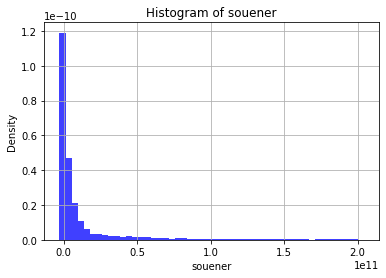

In [30]:
# the histogram of the data
n, bins, patches = plt.hist(halfData["Y_test"], 50, density=True, facecolor='blue', alpha=0.75)


plt.xlabel('souener')
plt.ylabel('Density')
plt.title('Histogram of souener')
plt.grid(True)
plt.show()


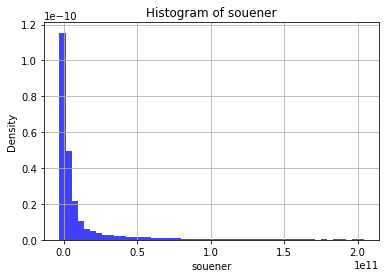

In [31]:
# the histogram of the data
n, bins, patches = plt.hist(halfData["Y_train"], 50, density=True, facecolor='blue', alpha=0.75)


plt.xlabel('souener')
plt.ylabel('Density')
plt.title('Histogram of souener')
plt.grid(True)
plt.show()

In [37]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="relu")(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
model.summary()

Model: "functional_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 4)            216         species_input[0][0]              
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 5)            0           Zmix[0][0]                       
                                                                 dense_31[0][0]        

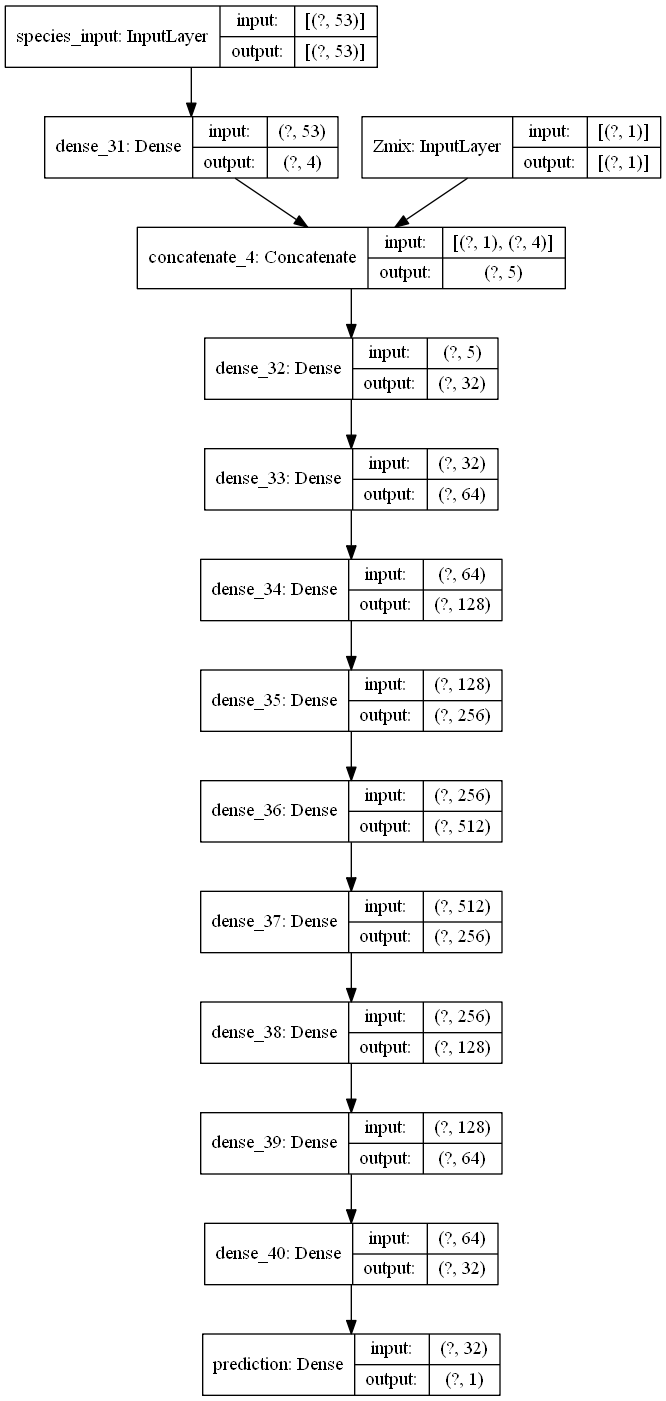

In [38]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [39]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [51]:
halfData = getHalfData()

In [52]:
halfData.keys()

dict_keys(['scaler_species', 'scaler_zmixpca', 'scaler_souener', 'X_tain', 'X_test', 'Zmix_train', 'Zmix_test', 'normalized_species_train', 'normalized_species_test', 'Y_test', 'Y_train', 'normalized_zmixpca_train', 'normalized_zmixpca_test', 'normalized_souener_train', 'normalized_souener_test'])

In [53]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=10, 
                          callbacks=[es])

Wall time: 5.65 s


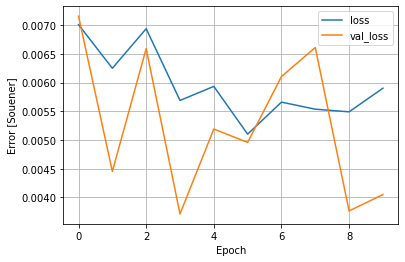

In [54]:
plot_loss(history)

In [56]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


In [58]:
scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [59]:
Y_pred = Y_pred.flatten()

In [60]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  7481880491882.785
Mean Absolute Error:  910315183.341378
Mean Percentage Error:  13.867121315477169
Total Squared Error:  4.921102650792046e+22
Mean Squared Error:  5.987471287008208e+18
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

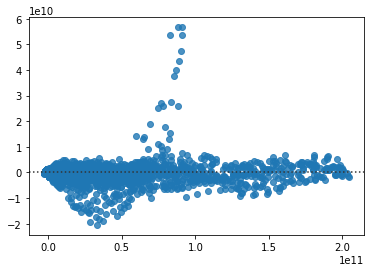

In [61]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Unconstrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding)

In [62]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear")(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
model.summary()

Model: "functional_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 4)            216         species_input[0][0]              
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 5)            0           Zmix[0][0]                       
                                                                 dense_41[0][0]        

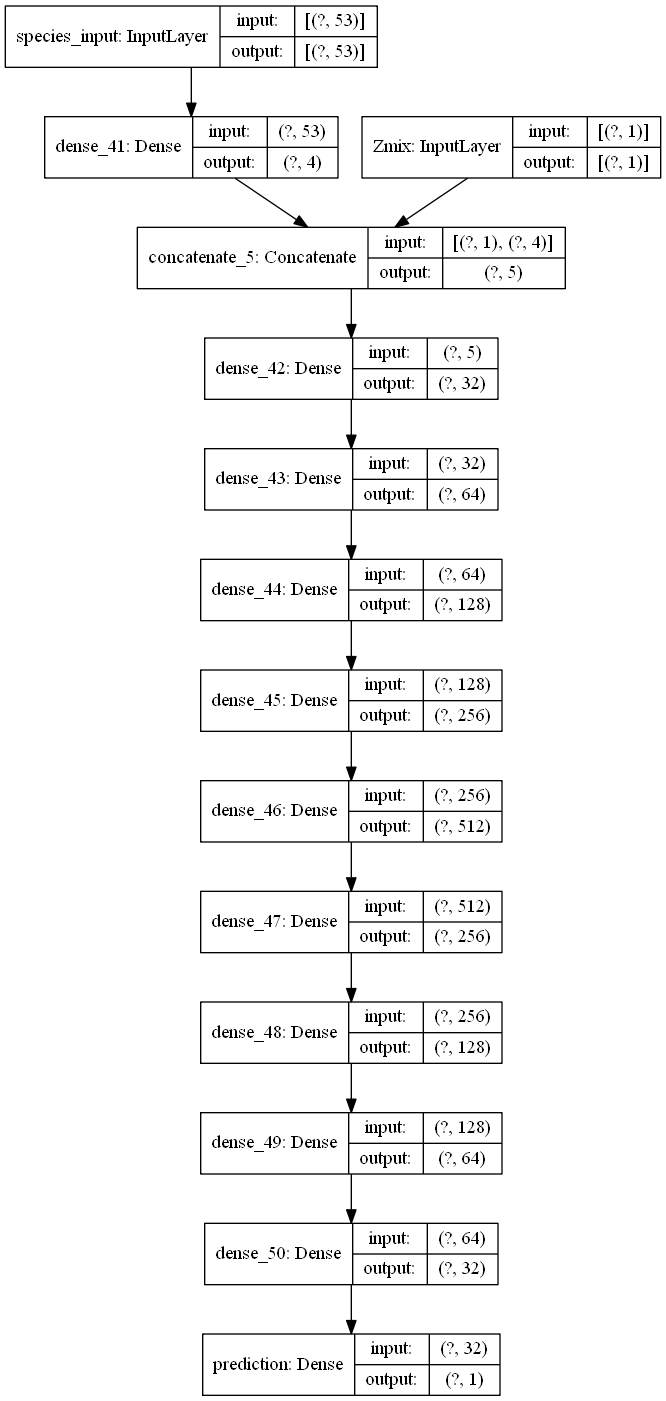

In [63]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [64]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [65]:
halfData = getHalfData()

In [66]:
halfData.keys()

dict_keys(['scaler_species', 'scaler_zmixpca', 'scaler_souener', 'X_tain', 'X_test', 'Zmix_train', 'Zmix_test', 'normalized_species_train', 'normalized_species_test', 'Y_test', 'Y_train', 'normalized_zmixpca_train', 'normalized_zmixpca_test', 'normalized_souener_train', 'normalized_souener_test'])

In [67]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=10, 
                          callbacks=[es])

Wall time: 6.21 s


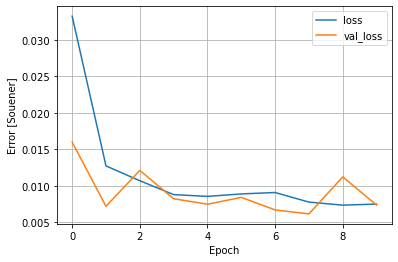

In [68]:
plot_loss(history)

In [69]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


In [70]:
scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [71]:
Y_pred = Y_pred.flatten()

In [72]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  13966027388621.277
Mean Absolute Error:  1699236815.7465966
Mean Percentage Error:  302.24562099965345
Total Squared Error:  1.906172478962673e+23
Mean Squared Error:  2.3192267659845153e+19
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

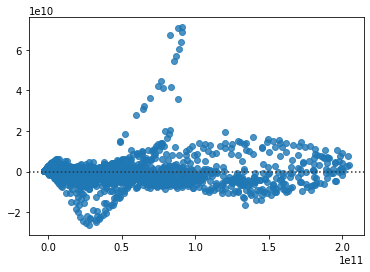

In [73]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; Unit Norm)

In [146]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear",kernel_constraint=UnitNorm(axis=0))(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
model.summary()

Model: "functional_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_91 (Dense)                (None, 4)            216         species_input[0][0]              
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 5)            0           Zmix[0][0]                       
                                                                 dense_91[0][0]       

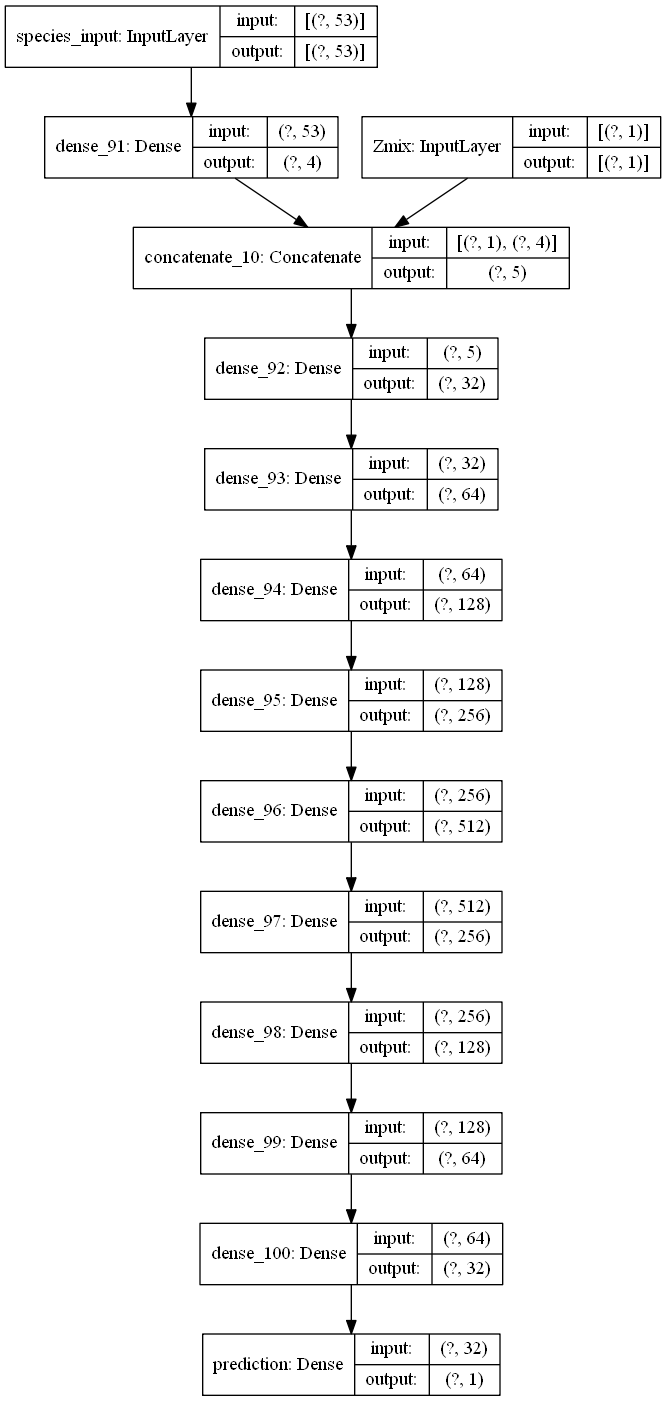

In [147]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [148]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [149]:
halfData = getHalfData()

In [150]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=100, 
                          callbacks=[es])

Wall time: 55.3 s


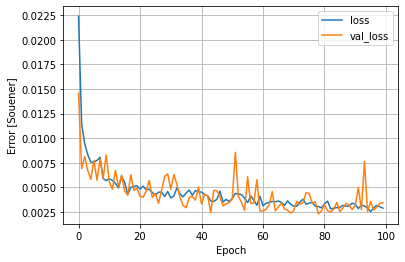

In [151]:
plot_loss(history)

In [152]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


In [153]:
scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [154]:
Y_pred = Y_pred.flatten()

In [155]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  6074904522666.828
Mean Absolute Error:  739129398.0614221
Mean Percentage Error:  128.27820794322312
Total Squared Error:  8.771586108122365e+22
Mean Squared Error:  1.067232766531496e+19
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

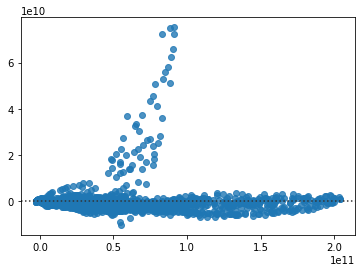

In [156]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; Orthogonal Weights)

In [85]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear",kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0))(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
model.summary()

Model: "functional_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_61 (Dense)                (None, 4)            216         species_input[0][0]              
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 5)            0           Zmix[0][0]                       
                                                                 dense_61[0][0]       

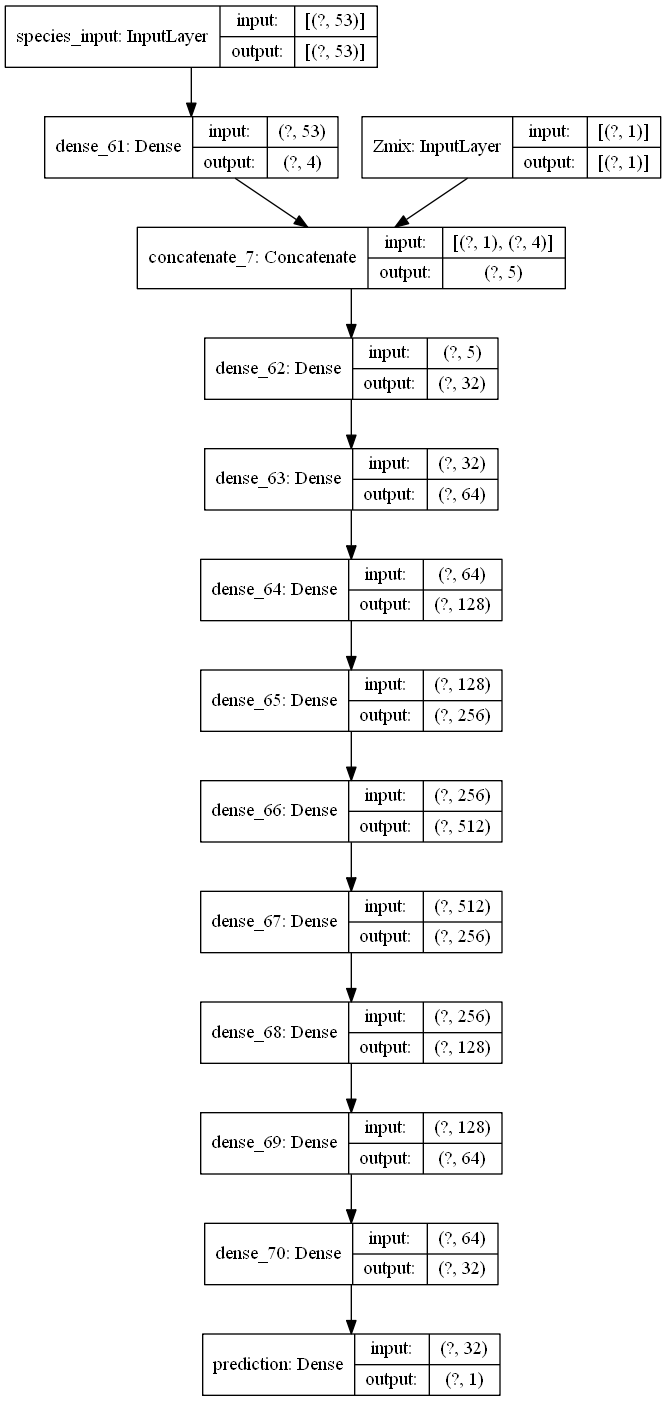

In [86]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [87]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [88]:
halfData = getHalfData()

In [117]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=100, 
                          callbacks=[es])

Epoch 00069: early stopping
Wall time: 39.7 s


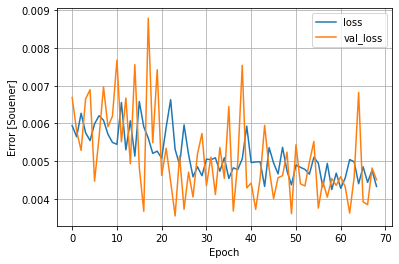

In [118]:
plot_loss(history)

In [119]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


In [120]:
scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [121]:
Y_pred = Y_pred.flatten()

In [122]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  4977507734207.722
Mean Absolute Error:  605609895.8763502
Mean Percentage Error:  86.98000571950584
Total Squared Error:  1.960659823128645e+22
Mean Squared Error:  2.385521137764503e+18
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

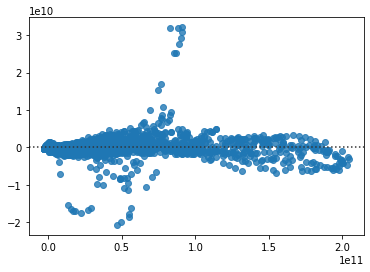

In [123]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; Uncorrelated Features)

In [124]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear",activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.))(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
model.summary()

Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_71 (Dense)                (None, 4)            216         species_input[0][0]              
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 5)            0           Zmix[0][0]                       
                                                                 dense_71[0][0]       

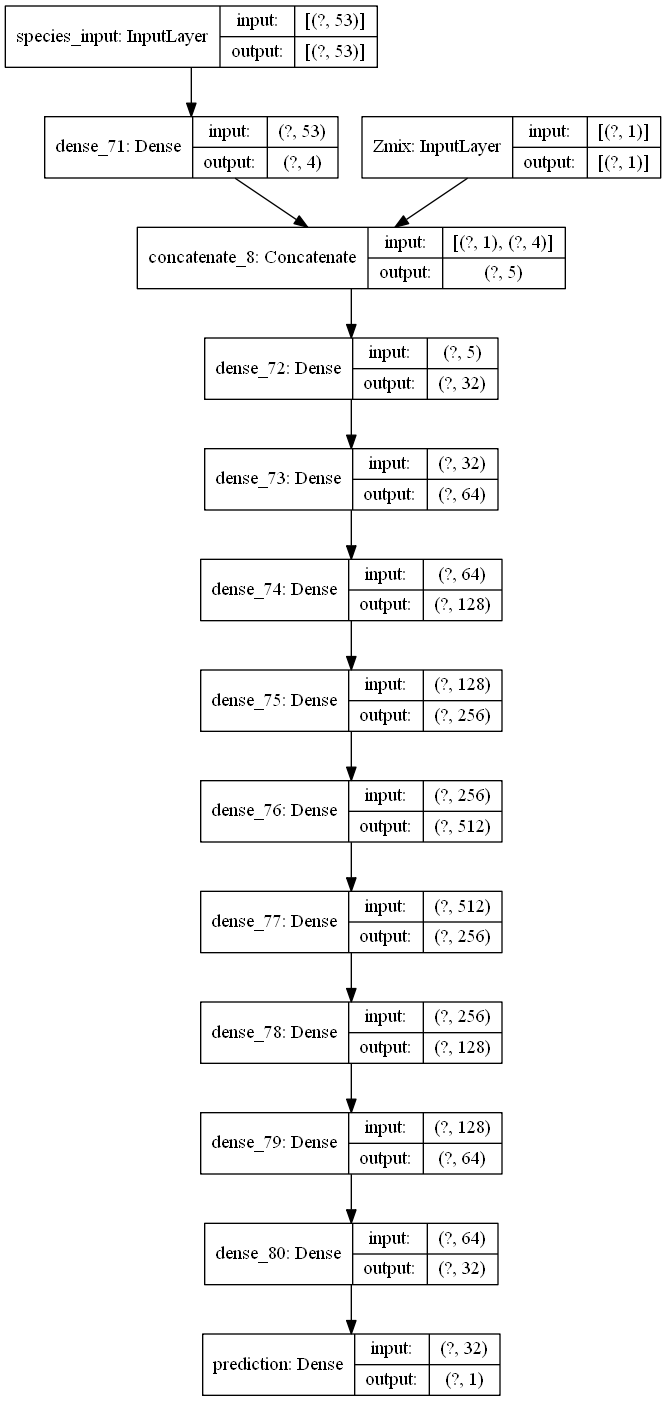

In [125]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [126]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [127]:
halfData = getHalfData()

In [128]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=100, 
                          callbacks=[es])

Wall time: 56.4 s


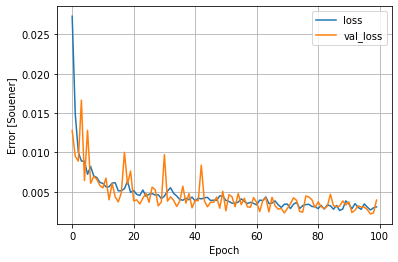

In [129]:
plot_loss(history)

In [130]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


In [131]:
scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [132]:
Y_pred = Y_pred.flatten()

In [133]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  7459171850205.456
Mean Absolute Error:  907552238.7401699
Mean Percentage Error:  34.836762083821505
Total Squared Error:  5.2517673963613e+22
Mean Squared Error:  6.389788777663098e+18
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

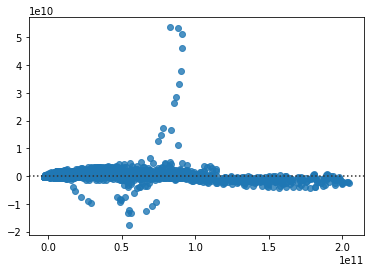

In [134]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; All Constraints)

In [135]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear",kernel_constraint=UnitNorm(axis=0),kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.))(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
model.summary()

Model: "functional_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_81 (Dense)                (None, 4)            216         species_input[0][0]              
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 5)            0           Zmix[0][0]                       
                                                                 dense_81[0][0]       

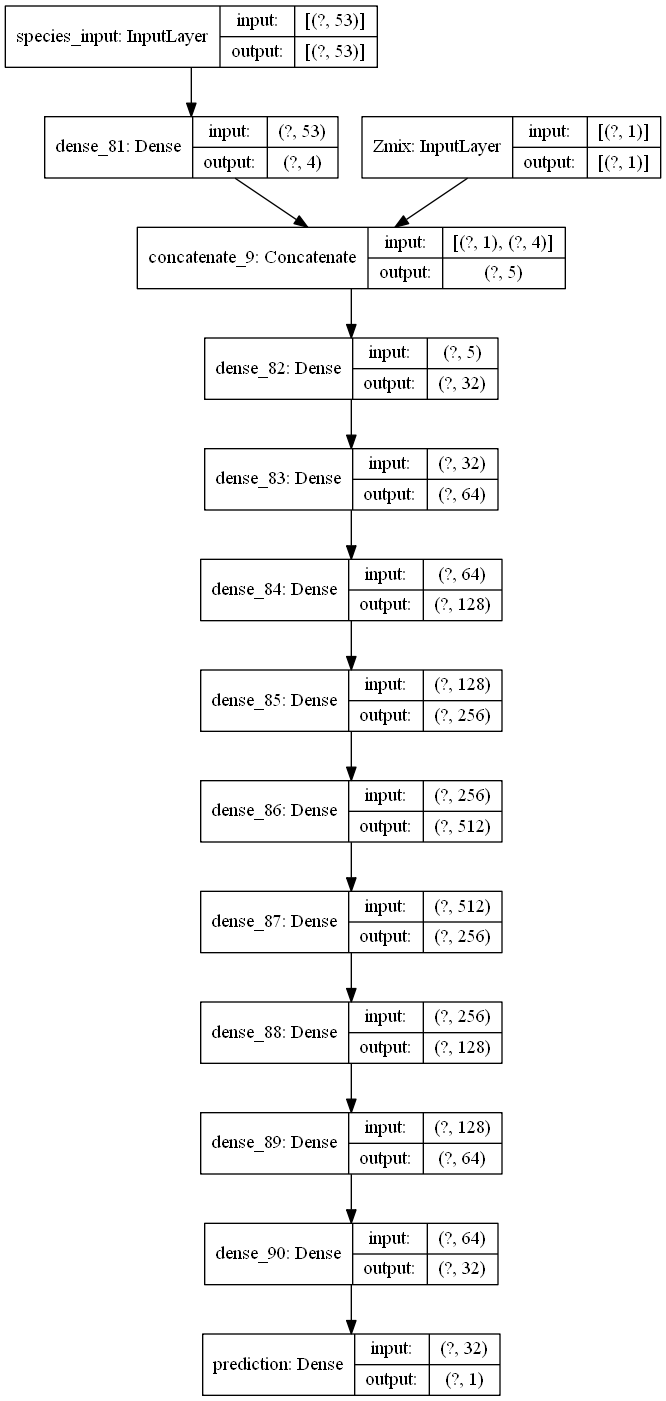

In [136]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [137]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [138]:
halfData = getHalfData()

In [139]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=100, 
                          callbacks=[es])

Wall time: 57.5 s


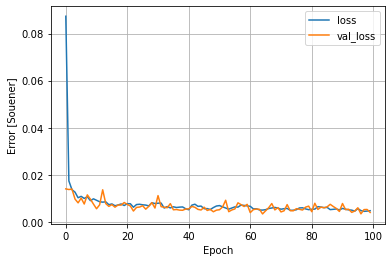

In [140]:
plot_loss(history)

In [141]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


In [142]:
scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [143]:
Y_pred = Y_pred.flatten()

In [144]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  4119625348938.7183
Mean Absolute Error:  501231944.1463339
Mean Percentage Error:  2.9320735330652115
Total Squared Error:  3.2751579170496422e+22
Mean Squared Error:  3.9848618044161603e+18
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

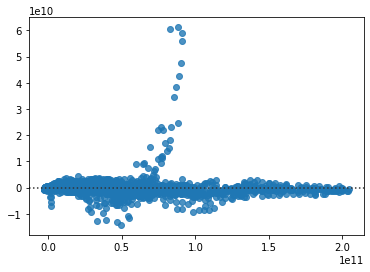

In [145]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Constrained DNN -- Linear Embedding (All Constraints; Reduced Architecture)

In [91]:
X_allSpecies = df[icovariates].values
X= df[zmix_pca_dim_cols].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_allSpecies_shuffled,X_shuffled, Y_shuffled = shuffle(X_allSpecies,X,Y, random_state=0)


X_allSpecies_train = X_allSpecies_shuffled[::2]
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]

X_allSpecies_test = X_allSpecies_shuffled[1::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]

Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

In [92]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler

# create scaler
scaler_species = MinMaxScaler()
# fit and transform in one step
normalized_species_train = scaler_species.fit_transform(X_allSpecies_train)
normalized_species_test = scaler_species.fit_transform(X_allSpecies_test)

# create scaler
scaler_zmixpca = MinMaxScaler()
# fit and transform in one step
normalized_zmixpca_train = scaler_zmixpca.fit_transform(X_train)
normalized_zmixpca_test = scaler_zmixpca.fit_transform(X_test)



scaler_souener = MinMaxScaler()#QuantileTransformer()#MinMaxScaler()
# fit and transform in one step



normalized_souener_train = scaler_souener.fit_transform(Y_train)
normalized_souener_test = scaler_souener.fit_transform(Y_test)

normalized_souener_train = normalized_souener_train.flatten()
normalized_souener_test = normalized_souener_test.flatten()

In [93]:
encoding_dim = 5
species_inputs = keras.Input(shape=(53,), name="species_input")

x = layers.Dense(encoding_dim, activation="linear",kernel_constraint=UnitNorm(axis=0),kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.))(species_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs],
    outputs=[souener_pred],
)


#
#,kernel_constraint=UnitNorm(axis=0)
#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense_60 (Dense)             (None, 5)                 270       
_________________________________________________________________
dense_61 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_62 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_63 (Dense)             (None, 256)               131328    
_________________________________________________________________
prediction (Dense)           (None, 1)                 257       
Total params: 264,975
Trainable params: 264,975
Non-trainable params: 0
_______________________________________________

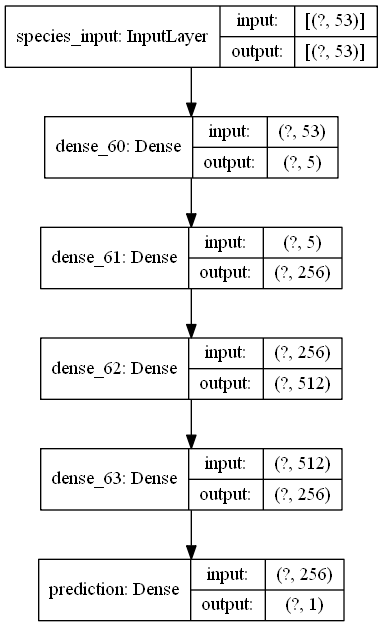

In [94]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [95]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [96]:
%%time
history = model.fit(normalized_species_train, 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=10, 
                          callbacks=[es])

Wall time: 6.15 s


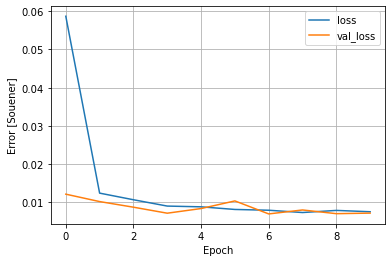

In [97]:
plot_loss(history)

In [98]:
predictions = model.predict(normalized_species_test)

normalized_souener_pred = predictions


In [99]:
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [100]:
Y_pred = Y_pred.flatten()

In [101]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  9441949521997.139
Mean Absolute Error:  1148795415.7436597
Mean Percentage Error:  180.96972467621762
Total Squared Error:  9.614274980763808e+22
Mean Squared Error:  1.1697621341725037e+19
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

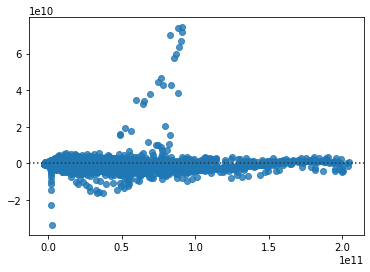

In [102]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))